In [277]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [278]:
model = BabyMAKROModelClass(name='Extended') # create an instance of the model

In [279]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [280]:
model.find_ss(do_print=True)

Labor supply and search and matching:
ss.S = 7.44,  ss.L = 56.28,  ss.delta_L = 0.07,  ss.v = 16.52,  ss.m_v = 0.23
Capital agency FOC:
ss.r_K = 0.14
Production firm pricing:
ss.r_ell = 2.71
Labor agency:
ss.ell = 55.87,  ss.w = 2.68
Government:
ss.B_G = 20.00,  ss.G = 10.00,  ss.tau = 0.07
Households:
solving for household behavior: result.converged = True
ss.C = 157.29,  ss.B = 431.70
Production firm FOCs:
ss.K = 557.43
Capital accumulation equation:
ss.I = 55.74
Output in production firm:
ss.Y = 229.56
Market clearing:
ss.C_Y = 110.10,  ss.G_Y = 7.00,  ss.I_Y = 36.23,  ss.X_Y = 76.23
[ ss.C_M = 47.19,  ss.G_M = 3.00,  ss.I_M = 19.51,  ss.X_M = 50.82 ] = ss.M = 120.52
ss.X = 127.05
Bargaining:
par.phi = 0.988


**Household behavior:**

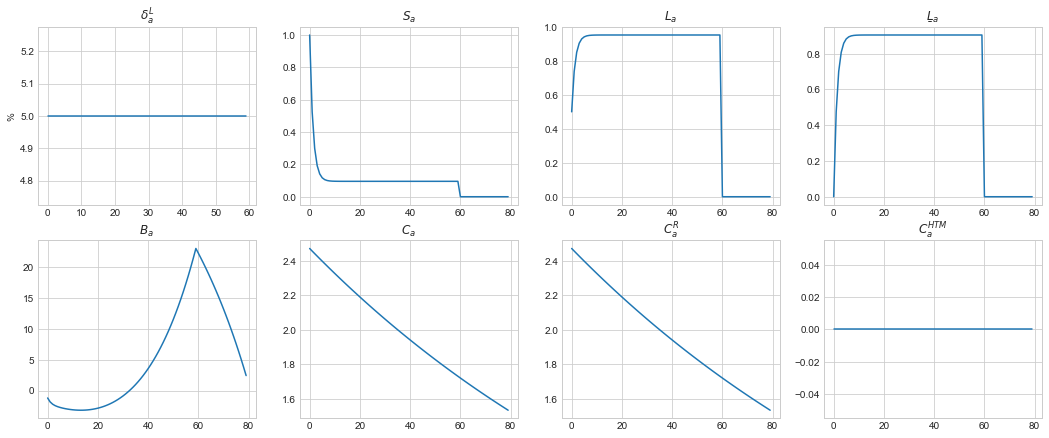

In [281]:
fig = plt.figure(figsize=(3*6,3*6/2.5))

ax = fig.add_subplot(2,4,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(2,4,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(2,4,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(2,4,4)
ax.plot(model.ss.L_ubar_a)
ax.set_title(r'$L\underbar_a$')

ax = fig.add_subplot(2,4,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$')

ax = fig.add_subplot(2,4,6)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(2,4,7)
ax.plot(model.ss.C_R)
ax.set_ylabel('')
ax.set_title('$C^R_a$')

ax = fig.add_subplot(2,4,8)
ax.plot(model.ss.C_HTM)
ax.set_ylabel('')
ax.set_title('$C^{HTM}_a$');

# Speed and error tests

In [282]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [283]:
%time model.evaluate_blocks(py=True)

CPU times: total: 219 ms
Wall time: 215 ms


**Check errors:**

In [284]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 6.77e+00
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 2.84e-14


**First numba evaluation:**

In [285]:
%time model.evaluate_blocks()

CPU times: total: 0 ns
Wall time: 4.07 ms


**Time:**

In [286]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

3.9 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.6 µs ± 588 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [287]:
%timeit model.evaluate_blocks(py=True)

197 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [288]:
model.calc_jac(do_print=True)

Jacobian calculated in 10.1 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [289]:
model.set_exo_ss()

model.set_exo_ss()Here we shock export demand:

In [290]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
sol.chi[:Tshock] = ss.chi + shock*persistence

Check errors when guessing at steady state -> excess demand

In [291]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 6.77e+00
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 7.62e-01


**Find IRF:**

In [292]:
model.find_IRF()

initial:
   max. abs. error = 6.77e+00
    0.00e+00 in bargaining_cond
    6.77e+00 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    7.62e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.1 secs
   max. abs. error = 6.77e+00
    1.03e-04 in bargaining_cond
    5.24e-02 in Bq_match
    3.18e-05 in FOC_capital_agency
    1.58e-03 in FOC_K_ell
    3.14e-02 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.1 secs
   max. abs. error = 5.24e-02
    6.32e-06 in bargaining_cond
    3.18e-03 in Bq_match
    2.21e-06 in FOC_capital_agency
    8.73e-05 in FOC_K_ell
    1.65e-03 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 3.18e-03
    2.91e-07 in bargaining_cond
    5.14e-05 in Bq_match
    1.74e-07 in FOC_capital_agency
    4.97e-06 in FOC_K_ell
    9.34e-05 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

**Plot:**

Note: resultater


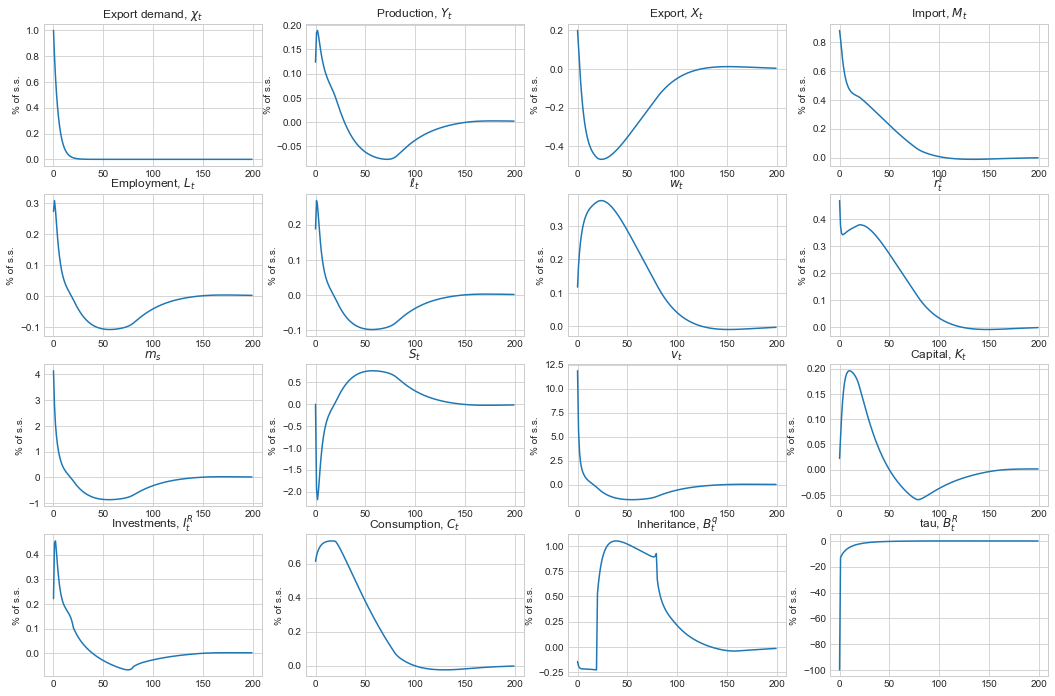

In [298]:
T_IRF = 200

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(4,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(4,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(4,4,3)
ax.plot((sol.X[:T_IRF]/(ss.X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export, $X_t$')

ax = fig.add_subplot(4,4,4)
ax.plot((sol.M[:T_IRF]/(ss.M)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import, $M_t$')

ax = fig.add_subplot(4,4,5)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(4,4,6)
ax.plot((sol.ell[:T_IRF]/(ss.ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$\ell_t$')

ax = fig.add_subplot(4,4,7)
ax.plot((sol.w[:T_IRF]/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$w_t$')

ax = fig.add_subplot(4,4,8)
ax.plot((sol.r_ell[:T_IRF]/(ss.r_ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$r^{\ell}_t$')

ax = fig.add_subplot(4,4,9)
ax.plot((sol.m_s[:T_IRF]/(ss.m_s)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$m_s$')

ax = fig.add_subplot(4,4,10)
ax.plot((sol.S[:T_IRF]/(ss.S)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$S_t$')

ax = fig.add_subplot(4,4,11)
ax.plot((sol.v[:T_IRF]/(ss.v)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$v_t$')

ax = fig.add_subplot(4,4,12)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(4,4,13)
ax.plot((sol.I[:T_IRF]/(ss.I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Investments, $I^R_t$')

ax = fig.add_subplot(4,4,14)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(4,4,15)
ax.plot((sol.Bq[:T_IRF]/(ss.Bq)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Inheritance, $B^q_t$')

ax = fig.add_subplot(4,4,16)
ax.plot((sol.tau[:T_IRF]/(ss.tau)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('tau, $B^R_t$');

print('Note: resultater')

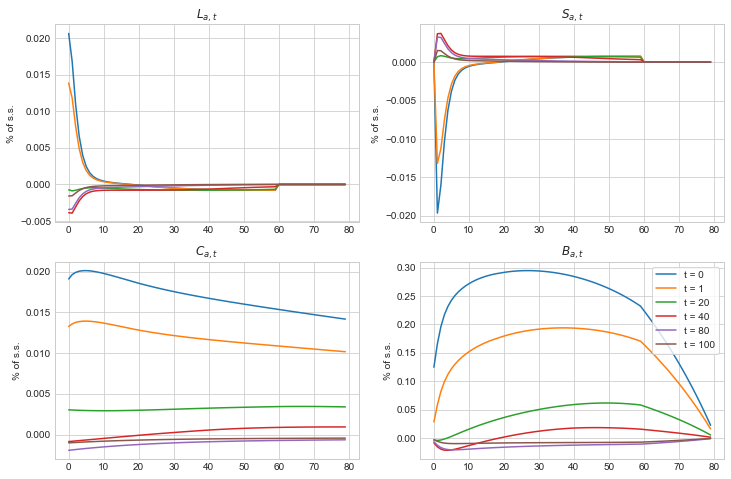

In [294]:
Periods = [0,1,20,40,80,100]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,2,1)
for t in Periods:
    L_a = np.zeros(par.A)
    for a in range(par.A):
        L_a[a] = sol.L_a[a,t+a]
    ax.plot(L_a-ss.L_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$L_{a,t}$')

ax = fig.add_subplot(2,2,2)
for t in Periods:
    S_a = np.zeros(par.A)
    for a in range(par.A):
        S_a[a] = sol.S_a[a,t+a]
    ax.plot(S_a-ss.S_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$S_{a,t}$')

ax = fig.add_subplot(2,2,3)
for t in Periods:
    C_a = np.zeros(par.A)
    for a in range(par.A):
        C_a[a] = sol.C_a[a,t+a]
    ax.plot(C_a-ss.C_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$C_{a,t}$')

ax = fig.add_subplot(2,2,4)
for t in Periods:
    B_a = np.zeros(par.A)
    for a in range(par.A):
        B_a[a] = sol.B_a[a,t+a]
    ax.plot(B_a-ss.B_a,label=f'{t = }')
ax.legend(frameon=True)
ax.set_ylabel('% of s.s.')
ax.set_title('$B_{a,t}$');



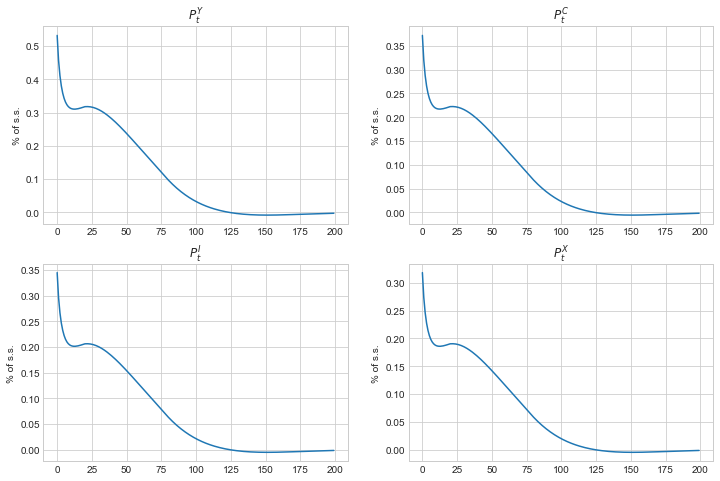

In [295]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2,2,1)
ax.plot((sol.P_Y[:T_IRF]/ss.P_Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^Y_t$')

ax = fig.add_subplot(2,2,2)
ax.plot((sol.P_C[:T_IRF]/ss.P_C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^C_t$')

ax = fig.add_subplot(2,2,3)
ax.plot((sol.P_I[:T_IRF]/(ss.P_I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^I_t$')

ax = fig.add_subplot(2,2,4)
ax.plot((sol.P_X[:T_IRF]/(ss.P_X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^X_t$');

# Comparison

In [266]:
model_copy = model.copy()
model_copy.par.Lambda = 0.15
model_copy.find_ss(0.50)
model_copy.calc_jac(do_print=True)

Labor supply and search and matching:
ss.S = 7.44,  ss.L = 56.28,  ss.delta_L = 0.07,  ss.v = 16.52,  ss.m_v = 0.23
Capital agency FOC:
ss.r_K = 0.14
Production firm pricing:
ss.r_ell = 2.71
Labor agency:
ss.ell = 55.87,  ss.w = 2.68
Government:
ss.B_G = 20.00,  ss.G = 10.00,  ss.tau = 0.07
Households:
solving for household behavior: result.converged = True
ss.C = 116.60,  ss.B = 367.63
Production firm FOCs:
ss.K = 557.43
Capital accumulation equation:
ss.I = 55.74
Output in production firm:
ss.Y = 229.56
Market clearing:
ss.C_Y = 81.62,  ss.G_Y = 7.00,  ss.I_Y = 36.23,  ss.X_Y = 104.71
[ ss.C_M = 34.98,  ss.G_M = 3.00,  ss.I_M = 19.51,  ss.X_M = 69.81 ] = ss.M = 127.30
ss.X = 174.52
Bargaining:
par.phi = 0.988
Jacobian calculated in 9.7 secs secs


In [267]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
model_copy.sol.chi[:Tshock] = model_copy.ss.chi + shock*persistence

In [268]:
model_copy.find_IRF()

initial:
   max. abs. error = 5.75e+00
    0.00e+00 in bargaining_cond
    5.75e+00 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    9.32e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.1 secs
   max. abs. error = 5.75e+00
    6.08e-05 in bargaining_cond
    1.87e-02 in Bq_match
    2.60e-05 in FOC_capital_agency
    1.02e-03 in FOC_K_ell
    2.30e-02 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.1 secs
   max. abs. error = 2.30e-02
    3.26e-06 in bargaining_cond
    7.46e-04 in Bq_match
    1.36e-06 in FOC_capital_agency
    4.85e-05 in FOC_K_ell
    1.03e-03 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 1.03e-03
    6.14e-08 in bargaining_cond
    1.10e-05 in Bq_match
    3.12e-08 in FOC_capital_agency
    1.05e-06 in FOC_K_ell
    2.27e-05 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

Text(0.5, 1.0, 'Production, $Y_t$')

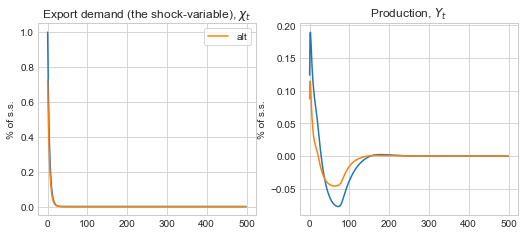

In [269]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.plot((model_copy.sol.chi[:T_IRF]/model_copy.ss.chi-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand (the shock-variable), $\chi_t$')
ax.legend(frameon=True)

ax = fig.add_subplot(3,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.plot((model_copy.sol.Y[:T_IRF]/model_copy.ss.Y-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')


Text(0.5, 1.0, 'wage, $w_t$')

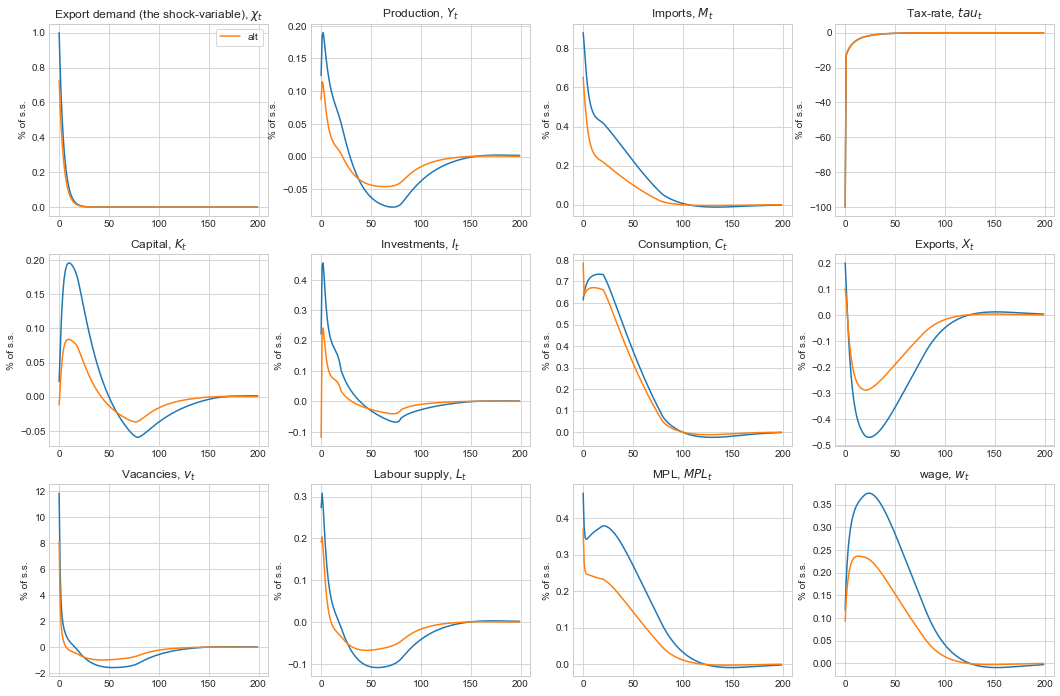

In [270]:
T_IRF = 200

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.plot((model_copy.sol.chi[:T_IRF]/model_copy.ss.chi-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand (the shock-variable), $\chi_t$')
ax.legend(frameon=True)

ax = fig.add_subplot(3,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.plot((model_copy.sol.Y[:T_IRF]/model_copy.ss.Y-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,4,3)
ax.plot((sol.M[:T_IRF]/ss.M-1)*100)
ax.plot((model_copy.sol.M[:T_IRF]/model_copy.ss.M-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Imports, $M_t$')

ax = fig.add_subplot(3,4,4)
ax.plot((sol.tau[:T_IRF]/ss.tau-1)*100)
ax.plot((model_copy.sol.tau[:T_IRF]/model_copy.ss.tau-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Tax-rate, $tau_t$')

ax = fig.add_subplot(3,4,5)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.plot((model_copy.sol.K[:T_IRF]/model_copy.ss.K-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,4,6)
ax.plot((sol.I[:T_IRF]/ss.I-1)*100)
ax.plot((model_copy.sol.I[:T_IRF]/model_copy.ss.I-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Investments, $I_t$')

ax = fig.add_subplot(3,4,7)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.plot((model_copy.sol.C[:T_IRF]/model_copy.ss.C-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,4,8)
ax.plot((sol.X[:T_IRF]/ss.X-1)*100)
ax.plot((model_copy.sol.X[:T_IRF]/model_copy.ss.X-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Exports, $X_t$')

ax = fig.add_subplot(3,4,9)
ax.plot((sol.v[:T_IRF]/ss.v-1)*100)
ax.plot((model_copy.sol.v[:T_IRF]/model_copy.ss.v-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Vacancies, $v_t$')

ax = fig.add_subplot(3,4,10)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.plot((model_copy.sol.L[:T_IRF]/model_copy.ss.L-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Labour supply, $L_t$')

ax = fig.add_subplot(3,4,11)
ax.plot((sol.MPL[:T_IRF]/ss.MPL-1)*100)
ax.plot((model_copy.sol.MPL[:T_IRF]/model_copy.ss.MPL-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('MPL, $MPL_t$')

ax = fig.add_subplot(3,4,12)
ax.plot((sol.w[:T_IRF]/ss.w-1)*100)
ax.plot((model_copy.sol.w[:T_IRF]/model_copy.ss.w-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('wage, $w_t$')

# Impulse-Response - Public Spending

In [271]:
model.set_exo_ss()

We shock G

In [272]:
Gshock = 50
shock = 0.01*ss.G
persistence = 0.8**np.arange(Gshock)
sol.G[:Gshock] = ss.G + shock*persistence

In [273]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 6.62e+00
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 7.00e-02


In [274]:
model.find_IRF()

initial:
   max. abs. error = 6.62e+00
    0.00e+00 in bargaining_cond
    6.62e+00 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    7.00e-02 in mkt_clearing

it = 0
 solve: t1-t0 = 0.1 secs
   max. abs. error = 6.62e+00
    3.60e-05 in bargaining_cond
    4.00e-02 in Bq_match
    8.66e-06 in FOC_capital_agency
    4.72e-04 in FOC_K_ell
    7.90e-03 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.1 secs
   max. abs. error = 4.00e-02
    1.24e-06 in bargaining_cond
    1.46e-03 in Bq_match
    6.54e-07 in FOC_capital_agency
    1.36e-05 in FOC_K_ell
    2.91e-04 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 1.46e-03
    9.80e-08 in bargaining_cond
    2.18e-05 in Bq_match
    5.16e-08 in FOC_capital_agency
    1.59e-06 in FOC_K_ell
    2.87e-05 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

Note: resultater


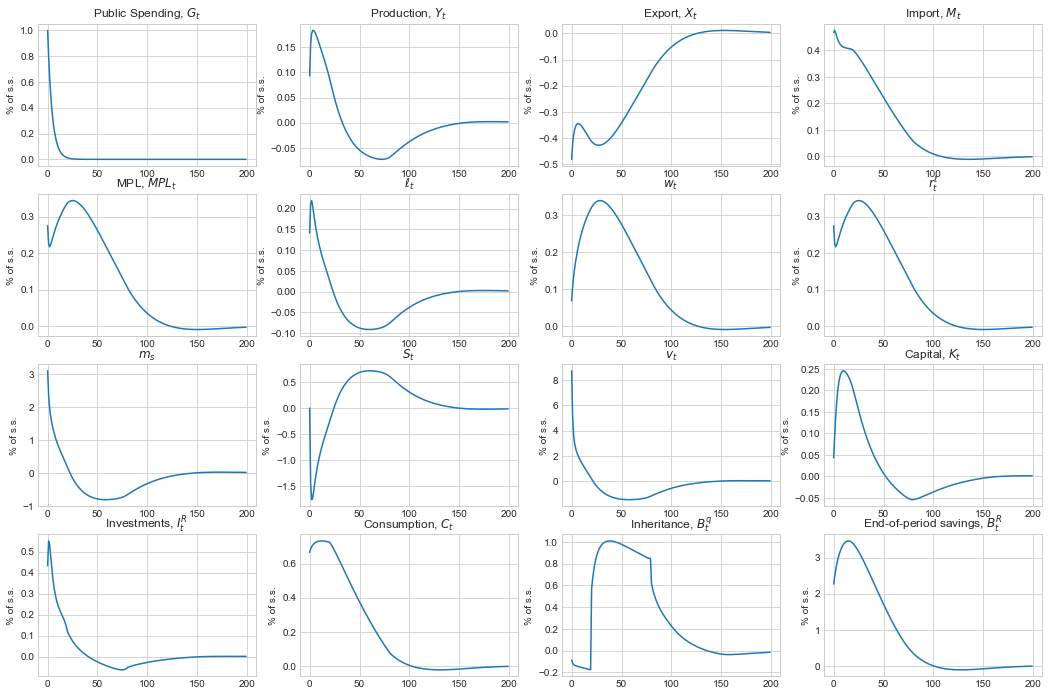

In [275]:
T_IRF = 200

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(4,4,1)
ax.plot((sol.G[:T_IRF]/ss.G-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Public Spending, $G_t$')

ax = fig.add_subplot(4,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(4,4,3)
ax.plot((sol.X[:T_IRF]/(ss.X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export, $X_t$')

ax = fig.add_subplot(4,4,4)
ax.plot((sol.M[:T_IRF]/(ss.M)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import, $M_t$')

ax = fig.add_subplot(4,4,5)
ax.plot((sol.MPL[:T_IRF]/ss.MPL-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('MPL, $MPL_t$')

ax = fig.add_subplot(4,4,6)
ax.plot((sol.ell[:T_IRF]/(ss.ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$\ell_t$')

ax = fig.add_subplot(4,4,7)
ax.plot((sol.w[:T_IRF]/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$w_t$')

ax = fig.add_subplot(4,4,8)
ax.plot((sol.r_ell[:T_IRF]/(ss.r_ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$r^{\ell}_t$')

ax = fig.add_subplot(4,4,9)
ax.plot((sol.m_s[:T_IRF]/(ss.m_s)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$m_s$')

ax = fig.add_subplot(4,4,10)
ax.plot((sol.S[:T_IRF]/(ss.S)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$S_t$')

ax = fig.add_subplot(4,4,11)
ax.plot((sol.v[:T_IRF]/(ss.v)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$v_t$')

ax = fig.add_subplot(4,4,12)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(4,4,13)
ax.plot((sol.I[:T_IRF]/(ss.I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Investments, $I^R_t$')

ax = fig.add_subplot(4,4,14)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(4,4,15)
ax.plot((sol.Bq[:T_IRF]/(ss.Bq)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Inheritance, $B^q_t$')

ax = fig.add_subplot(4,4,16)
ax.plot((sol.B[:T_IRF]/(ss.B)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('End-of-period savings, $B^R_t$');

print('Note: resultater')

Note: resultater priser mm.


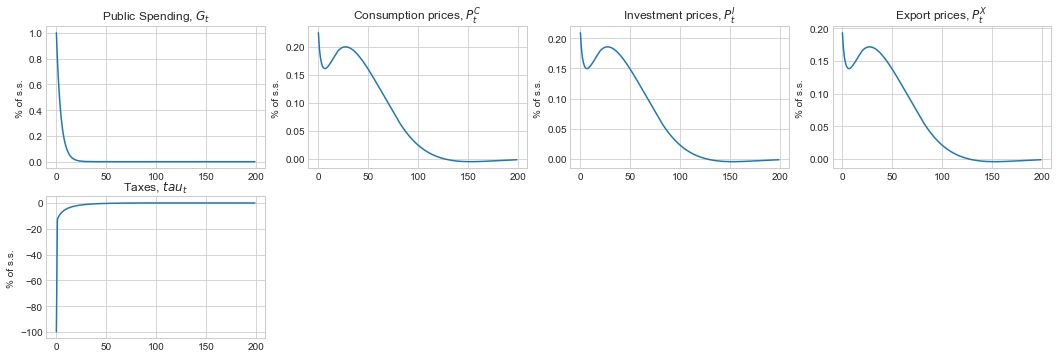

In [276]:
T_IRF = 200

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(4,4,1)
ax.plot((sol.G[:T_IRF]/ss.G-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Public Spending, $G_t$')

ax = fig.add_subplot(4,4,2)
ax.plot((sol.P_C[:T_IRF]/ss.P_C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption prices, $P^C_t$')

ax = fig.add_subplot(4,4,3)
ax.plot((sol.P_I[:T_IRF]/ss.P_I-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Investment prices, $P^I_t$')

ax = fig.add_subplot(4,4,4)
ax.plot((sol.P_X[:T_IRF]/ss.P_X-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export prices, $P^X_t$')

ax = fig.add_subplot(4,4,5)
ax.plot((sol.tau[:T_IRF]/ss.tau-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Taxes, $tau_t$')




print('Note: resultater priser mm.')